LSTM

In [1]:
!%pip install yfinance


[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [3]:

# Baixar dados históricos da ação MGLU3 dos últimos 5 anos
mglu3 = yf.download('MGLU3.SA', period="5y")


[*********************100%***********************]  1 of 1 completed


In [4]:
# Exibir os primeiros 5 registros
print(mglu3.head(5))

Price        Adj Close       Close        High         Low        Open  \
Ticker        MGLU3.SA    MGLU3.SA    MGLU3.SA    MGLU3.SA    MGLU3.SA   
Date                                                                     
2020-02-06  130.170090  130.547760  135.972626  130.477600  135.621887   
2020-02-07  126.439621  126.806458  130.781586  125.099495  130.243774   
2020-02-10  122.126266  122.480591  129.846268  120.516411  126.268646   
2020-02-11  126.532883  126.899994  128.139297  120.960693  124.398003   
2020-02-12  130.426559  130.804962  132.231339  126.853226  127.507957   

Price        Volume  
Ticker     MGLU3.SA  
Date                 
2020-02-06  4401044  
2020-02-07  4178576  
2020-02-10  5487385  
2020-02-11  4057933  
2020-02-12  4501544  


In [5]:
# Pegue os 7 últimos elementos do dataframe 'mglu3'
mglu3.tail(7)

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,MGLU3.SA,MGLU3.SA,MGLU3.SA,MGLU3.SA,MGLU3.SA,MGLU3.SA
Date,,,,,,
2025-01-29,6.59,6.59,6.86,6.46,6.83,20659600
2025-01-30,7.27,7.27,7.42,6.71,6.71,31780200
2025-01-31,7.46,7.46,7.56,7.20,7.31,25872400
2025-02-03,7.22,7.22,7.32,7.08,7.32,22910800
2025-02-04,7.24,7.24,7.30,6.81,7.15,28804500
2025-02-05,6.88,6.88,7.21,6.86,7.21,20919700
2025-02-06,7.39,7.39,7.42,6.91,6.91,27362200


In [6]:
# Pega somente o att "Close" e armazena em um array bidimensional
mglu3_close = mglu3['Close'].dropna().to_numpy().reshape(-1, 1)
mglu3_close

array([[130.54776001],
       [126.80645752],
       [122.48059082],
       ...,
       [  7.23999977],
       [  6.88000011],
       [  7.38999987]])

In [7]:
mglu3_close[0].size

1

In [8]:
# Criar um DataFrame com os valores ajustados
data = pd.DataFrame(mglu3_close)
data.columns = ['Close']

In [9]:
# Normalizar os dados para os modelos
scaler = MinMaxScaler(feature_range=(0, 1))
data['Scaled_Close'] = scaler.fit_transform(data[['Close']])

In [10]:
data

,Close,Scaled_Close
0,130.547760,0.497089
1,126.806458,0.482180
2,122.480591,0.464941
3,126.899994,0.482553
4,130.804962,0.498114
...,...,...
1240,7.460000,0.006575
1241,7.220000,0.005619
1242,7.240000,0.005699
1243,6.880000,0.004264


In [11]:
# Função para criar janelas de dados
# janela de dados = quantidade de dias do X
def create_dataset(data, window_size=60):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [12]:
# Criar conjunto de dados
window_size = 60 # 60 ultimos dias
scaled_data = data['Scaled_Close'].values
X, y = create_dataset(scaled_data, window_size)

In [13]:
X

array([[0.49708945, 0.48218007, 0.46494117, ..., 0.45618192, 0.4446272 ,
        0.49075295],
       [0.48218007, 0.46494117, 0.48255282, ..., 0.4446272 , 0.49075295,
        0.50603501],
       [0.46494117, 0.48255282, 0.49811442, ..., 0.49075295, 0.50603501,
        0.4943871 ],
       ...,
       [0.01582075, 0.01661777, 0.0156215 , ..., 0.00581821, 0.00657538,
        0.00561896],
       [0.01661777, 0.0156215 , 0.01422672, ..., 0.00657538, 0.00561896,
        0.00569866],
       [0.0156215 , 0.01422672, 0.01510344, ..., 0.00561896, 0.00569866,
        0.00426403]])

In [14]:
len(X)

1185

In [15]:
print(X[1].size)

60


In [16]:
X.size

71100

In [17]:
y[0].size

1

In [18]:
# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [19]:
# Ajustar o formato para o LSTM
X_train_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [20]:
# Criar o modelo LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1))

c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
# Compilar o modelo
# A função de loss é a forma de medir o erro do modelo, que nesse caso
#é o classico erro médio quadrático da que é usado em regressão linear
#otimizador e medida de erro
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [22]:
# Treinar o modelo
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.1232
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0052
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0044
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0041
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0031
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0037
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0028
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0035
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0031
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0028
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0029
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0028
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0026
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0027
Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0022
Epo

In [23]:
# Fazer previsões
lstm_predictions = lstm_model.predict(X_test_lstm)

# Inverter a normalização
lstm_predictions = scaler.inverse_transform(lstm_predictions)
lstm_predictions

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step


array([[19.987448 ],
       [20.110073 ],
       [20.257915 ],
       [20.371065 ],
       [20.44815  ],
       [20.46479  ],
       [20.426632 ],
       [20.355837 ],
       [20.239899 ],
       [20.107367 ],
       [19.974806 ],
       [19.838999 ],
       [19.682499 ],
       [19.589613 ],
       [19.482027 ],
       [19.409365 ],
       [19.335312 ],
       [19.228334 ],
       [19.097502 ],
       [18.890154 ],
       [18.65767  ],
       [18.408646 ],
       [18.150156 ],
       [17.877708 ],
       [17.583645 ],
       [17.328918 ],
       [17.085468 ],
       [16.897522 ],
       [16.779432 ],
       [16.69266  ],
       [16.612408 ],
       [16.505219 ],
       [16.318    ],
       [16.076641 ],
       [15.808088 ],
       [15.523392 ],
       [15.26153  ],
       [15.024643 ],
       [14.772687 ],
       [14.51721  ],
       [14.251865 ],
       [14.01258  ],
       [13.814299 ],
       [13.610571 ],
       [13.462846 ],
       [13.418456 ],
       [13.45143  ],
       [13.55

In [24]:
#pegando o erro médio quadrático (RMSE)
rmse = np.sqrt(np.mean(lstm_predictions - y_test) ** 2)
rmse
len(lstm_predictions)

237

In [25]:
#criando o grafico do modelo
treinamento = mglu3.iloc[:len(X_train), :]
treinamento

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,MGLU3.SA,MGLU3.SA,MGLU3.SA,MGLU3.SA,MGLU3.SA,MGLU3.SA
Date,,,,,,
2020-02-06,130.170090,130.547760,135.972626,130.477600,135.621887,4401044
2020-02-07,126.439621,126.806458,130.781586,125.099495,130.243774,4178576
2020-02-10,122.126266,122.480591,129.846268,120.516411,126.268646,5487385
2020-02-11,126.532883,126.899994,128.139297,120.960693,124.398003,4057933
2020-02-12,130.426559,130.804962,132.231339,126.853226,127.507957,4501544
...,...,...,...,...,...,...
2023-11-23,20.296516,20.296516,20.483582,19.267660,19.548258,7946214
2023-11-24,18.612934,18.612934,20.296516,18.519402,20.202984,19154295


In [26]:
mglu3['Close']

Ticker,MGLU3.SA
Date,
2020-02-06,130.547760
2020-02-07,126.806458
2020-02-10,122.480591
2020-02-11,126.899994
2020-02-12,130.804962
...,...
2025-01-31,7.460000
2025-02-03,7.220000
2025-02-04,7.240000


In [27]:
df_teste = pd.DataFrame({
    "Close": mglu3['Close'].iloc[len(X_train) + 60 : len(X_train) + 60 + len(lstm_predictions)].values.flatten(),
    "predicoes": lstm_predictions.flatten()
})


In [28]:
mglu3['Close']

Ticker,MGLU3.SA
Date,
2020-02-06,130.547760
2020-02-07,126.806458
2020-02-10,122.480591
2020-02-11,126.899994
2020-02-12,130.804962
...,...
2025-01-31,7.460000
2025-02-03,7.220000
2025-02-04,7.240000


In [29]:
df_teste = pd.DataFrame({
    "Date": mglu3.index[len(X_train) + 60 : len(X_train) + 60 + len(lstm_predictions)],  # Pegando as datas corretas
    "Close": mglu3['Close'].iloc[len(X_train) + 60 : len(X_train) + 60 + len(lstm_predictions)].values.flatten(),
    "predicoes": lstm_predictions.flatten()
})

# Garantindo que a coluna "Date" seja de fato uma data (caso ainda não seja)
df_teste["Date"] = pd.to_datetime(df_teste["Date"])

# Definir "Date" como índice (opcional, se quiser que o gráfico fique melhor organizado)
df_teste.set_index("Date", inplace=True)


In [30]:
df_teste

,Close,predicoes
Date,,
2024-02-29,21.299999,19.987448
2024-03-01,22.200001,20.110073
2024-03-04,21.299999,20.257915
2024-03-05,21.200001,20.371065
2024-03-06,20.600000,20.448151
...,...,...
2025-01-31,7.460000,5.352344
2025-02-03,7.220000,5.479280
2025-02-04,7.240000,5.605472


In [31]:
print(len(mglu3['Close'].iloc[len(X_train) + 60:]))  # Deve imprimir 237
print(len(lstm_predictions))  # Deve imprimir 237


237
237


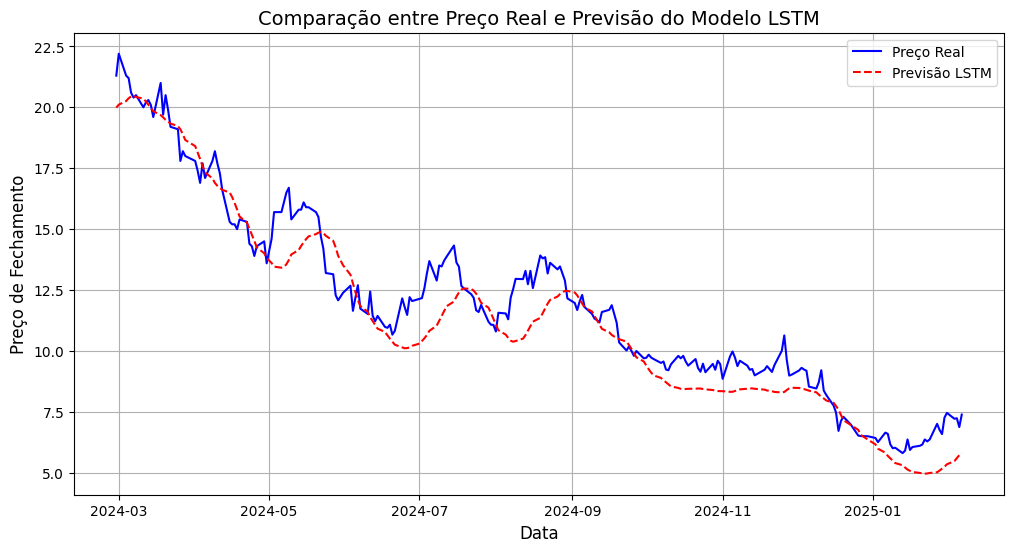

In [32]:
import matplotlib.pyplot as plt

# Criar o gráfico
plt.figure(figsize=(12, 6))
plt.plot(df_teste.index, df_teste["Close"], label="Preço Real", linestyle="-", color="blue")
plt.plot(df_teste.index, df_teste["predicoes"], label="Previsão LSTM", linestyle="--", color="red")

# Adicionar títulos e legendas
plt.title("Comparação entre Preço Real e Previsão do Modelo LSTM", fontsize=14)
plt.xlabel("Data", fontsize=12)
plt.ylabel("Preço de Fechamento", fontsize=12)
plt.legend()
plt.grid(True)

# Mostrar o gráfico
plt.show()


In [33]:
# Calcular métricas
mae = mean_absolute_error(df_teste["Close"], df_teste["predicoes"])
mse = mean_squared_error(df_teste["Close"], df_teste["predicoes"])
rmse = mean_squared_error(df_teste["Close"], df_teste["predicoes"], squared=False)  # RMSE é a raiz quadrada do MSE
r2 = r2_score(df_teste["Close"], df_teste["predicoes"])

# Exibir resultados
print(f"📊 MÉTRICAS DE ERRO DO MODELO LSTM 📊")
print(f"MAE  (Erro Absoluto Médio)  : {mae:.4f}")
print(f"MSE  (Erro Quadrático Médio): {mse:.4f}")
print(f"RMSE (Raiz do Erro Médio)   : {rmse:.4f}")
print(f"R²   (Coeficiente de Determinação): {r2:.4f}")


📊 MÉTRICAS DE ERRO DO MODELO LSTM 📊
MAE  (Erro Absoluto Médio)  : 0.9360
MSE  (Erro Quadrático Médio): 1.3712
RMSE (Raiz do Erro Médio)   : 1.1710
R²   (Coeficiente de Determinação): 0.9068


c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
